# You might have to open the raw data file in libra office and merge the dilimiters

In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Import curve fitting package from scipy
from sklearn.linear_model import LinearRegression

# import os
import os, sys, shutil



raw_data = pd.read_csv('154253_230202_OT2_BRADFORD.csv', sep=',', header=None)


In [2]:
# get the row index of the cell that contains the string "Corrected [Bradford:595]"
row_index = raw_data.index[raw_data.loc[:,0]=="Corrected [Bradford:595]"][0]

corrected_data = raw_data.iloc[row_index+2: row_index + 10, 1 : 13].reset_index(drop=True)
print(corrected_data)

      1      2      3      4      5                         6      7      8   \
0  1.422  1.420  1.459  0.595  0.601                     0.607  0.649  0.595   
1  1.042  1.076  1.077  1.383  1.373                     1.386  1.377  1.374   
2  0.778  0.801  0.800  1.720  1.705                      1.73  1.721  1.735   
3  1.929  1.923  1.920  1.937  1.945  Corrected [Bradford:595]    NaN    NaN   
4  2.137  2.139  2.148  2.143  2.144  Corrected [Bradford:595]    NaN    NaN   
5  2.319  2.306  2.307  2.306  2.378  Corrected [Bradford:595]    NaN    NaN   
6  2.489  2.512  2.499  2.495  2.462  Corrected [Bradford:595]    NaN    NaN   
7  2.567  2.564  2.552  2.555  2.559  Corrected [Bradford:595]    NaN    NaN   

                         9   10  11  12  
0  Corrected [Bradford:595] NaN NaN NaN  
1  Corrected [Bradford:595] NaN NaN NaN  
2  Corrected [Bradford:595] NaN NaN NaN  
3                       NaN NaN NaN NaN  
4                       NaN NaN NaN NaN  
5                       NaN

In [3]:
# hot fix to deal with the parser not being able to parse "blank wells".
# remove at a later date

calibrants = corrected_data.iloc[:,0:5]
print(calibrants)
print(type(calibrants.iloc[0,0]))

       1      2      3      4      5
0  1.422  1.420  1.459  0.595  0.601
1  1.042  1.076  1.077  1.383  1.373
2  0.778  0.801  0.800  1.720  1.705
3  1.929  1.923  1.920  1.937  1.945
4  2.137  2.139  2.148  2.143  2.144
5  2.319  2.306  2.307  2.306  2.378
6  2.489  2.512  2.499  2.495  2.462
7  2.567  2.564  2.552  2.555  2.559
<class 'numpy.float64'>


In [4]:
new_low = calibrants.iloc[0,0:3].copy()
new_high = calibrants.iloc[2,0:3].copy()


calibrants.iloc[0,0:3] = new_high
calibrants.iloc[2,0:3] = new_low

print(calibrants)

       1      2      3      4      5
0  0.778  0.801  0.800  0.595  0.601
1  1.042  1.076  1.077  1.383  1.373
2  1.422  1.420  1.459  1.720  1.705
3  1.929  1.923  1.920  1.937  1.945
4  2.137  2.139  2.148  2.143  2.144
5  2.319  2.306  2.307  2.306  2.378
6  2.489  2.512  2.499  2.495  2.462
7  2.567  2.564  2.552  2.555  2.559


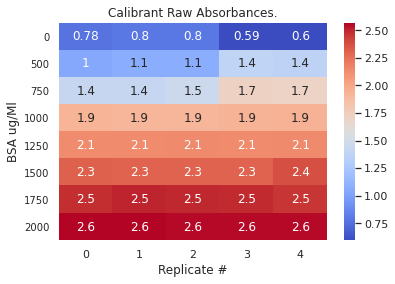

In [5]:
# reshape

calibrants_np = calibrants.to_numpy()

replicates = 5

# real concs in wells. Stocks in ug/ml diluted by 20x
calibrant_range = ["0","500","750","1000", "1250", "1500", "1750","2000"]

#calibrants_np_2d = np.reshape(calibrants_np, (int(len(calibrants_np)/replicates), replicates))

import seaborn as sns

sns.set()
ax1 = sns.heatmap(calibrants_np, annot=True, cmap="coolwarm")
ax1.set_ylabel("BSA ug/Ml")
ax1.set_title("Calibrant Raw Absorbances.")
ax1.set_xlabel("Replicate #")
plt.yticks(np.arange(8)+0.5,calibrant_range, rotation=0, fontsize="10")

plt.savefig("output/BSA_absorbances_heat.png")

plt.show()

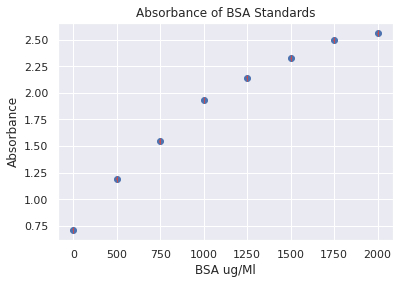

In [6]:
calibrants_df = pd.DataFrame(calibrants_np, columns=["Rep1", "Rep2", "Rep3", "Rep4", "Rep5"], index=calibrant_range)

calibrants_df["Mean"] = calibrants_df.mean(axis=1)
calibrants_df["SEM"] = calibrants_df.iloc[:,:3].sem(axis=1)

calibrants_df_avg = calibrants_df[["Mean", "SEM"]]

#plot 

x = calibrants_df_avg.index
y = calibrants_df_avg['Mean']

plt.scatter(x,y)
plt.errorbar(x,y, yerr=calibrants_df_avg['SEM'], fmt="|", color="r")

plt.title("Absorbance of BSA Standards")
plt.ylabel("Absorbance")
plt.xlabel("BSA ug/Ml")
plt.savefig("output/BSA_Standard_Absorbances_scatter.png")
plt.show()


[0.0, 500.0, 750.0, 1000.0, 1250.0, 1500.0, 1750.0, 2000.0]
coefficient of determination: 0.9683250252191316


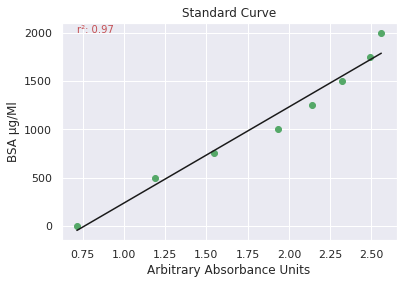

In [7]:

# calibrant concs
calibrant_range_numerical = [float(ele) for ele in calibrant_range]
print(calibrant_range_numerical)

# fit curves
#function for looping?
model = LinearRegression()
# fitc data in to array and reverse the order
x = np.array(calibrants_df_avg["Mean"]).reshape(-1,1)

# List of nM concs into array
y = np.array(calibrant_range_numerical).reshape(-1,1)

x = x.reshape(-1,1)

# Fit
model.fit(x,y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

#Plot
plt.scatter(x, y, color='g')
plt.plot(x, model.predict(x), color='k')

textstr ='r²: ' +str(round(r_sq,2))
plt.text(calibrants_df_avg["Mean"].min(), calibrant_range_numerical[-1], textstr, color='r', fontsize=10)

plt.title('Standard Curve')
plt.xlabel('Arbitrary Absorbance Units')
plt.ylabel('BSA μg/Ml')
plt.savefig("output/BSA_Standard_Curve.png")
plt.show()




In [8]:
sample_data = pd.read_csv("Preconc_230308_OT2_BRADFORD_samples.csv", sep=',', header=None)
replicates = 3

sample_data = sample_data.iloc[6:,7:10]

sample_list = ["1x","5x","10x", "20x"]

sample_data

,7,8,9
6,4.543,4.060,4.506
7,3.043,3.056,3.069
8,2.453,2.469,2.508
9,1.431,1.434,1.425


      Rep1   Rep2   Rep3
1x   4.543  4.060  4.506
5x   3.043  3.056  3.069
10x  2.453  2.469  2.508
20x  1.431  1.434  1.425


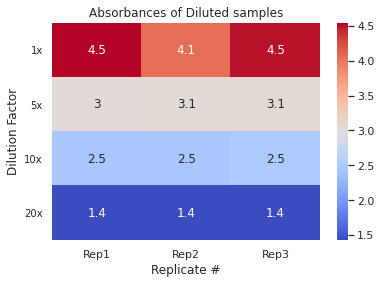

In [9]:
sample_data.columns = ["Rep1", "Rep2", "Rep3"]
sample_data.index = sample_list

print(sample_data)

sns.set()


sns.heatmap(sample_data, annot=True, cmap="coolwarm")



plt.ylabel("Dilution Factor")
plt.title("Absorbances of Diluted samples")
plt.xlabel("Replicate #")
plt.yticks(np.arange(sample_data.shape[0])+0.5, sample_list, rotation=0, fontsize="10")
plt.savefig("output/Sample_Absorbances_heat.png")



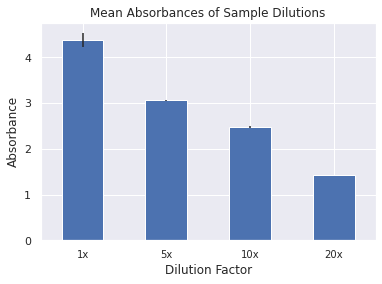

In [10]:


sample_data["Mean"] = sample_data.mean(axis=1)
sample_data["SEM"] = sample_data.iloc[:,:3].sem(axis=1)


samples_df_avg = sample_data[["Mean", "SEM"]]

ax3 = samples_df_avg.plot(kind="bar", yerr="SEM", legend=False)


ax3.set_title("Mean Absorbances of Sample Dilutions")
ax3.set_ylabel("Absorbance")
ax3.set_xlabel("Dilution Factor")
plt.xticks(np.arange(samples_df_avg.shape[0]),sample_list, rotation=0, fontsize="10")
plt.savefig("output/Sample_Absorbances_Bar.png")

In [11]:
#### subset samples that don't fall in linear range
acceptable_samples = sample_data


#get the index again for the names
acceptable_samples_list = acceptable_samples.index
print(acceptable_samples)

      Rep1   Rep2   Rep3      Mean       SEM
1x   4.543  4.060  4.506  4.369667  0.155201
5x   3.043  3.056  3.069  3.056000  0.007506
10x  2.453  2.469  2.508  2.476667  0.016333
20x  1.431  1.434  1.425  1.430000  0.002646


In [12]:
# convert samples
predicted_ug_per_ml = model.predict(np.array(acceptable_samples.iloc[:,:3]).reshape(-1,1))
predicted_ug_per_ml = np.reshape(predicted_ug_per_ml,(int(len(predicted_ug_per_ml)/replicates), replicates))
predicted_ug_per_ml = pd.DataFrame(predicted_ug_per_ml, columns=["Rep1", "Rep2", "Rep3"], index = acceptable_samples_list)

print(predicted_ug_per_ml)

            Rep1         Rep2         Rep3
1x   3762.534474  3281.703796  3725.700654
5x   2269.271500  2282.213113  2295.154725
10x  1681.921397  1697.849536  1736.674373
20x   664.511558   667.498084   658.538506


In [13]:
#account for the dilutions
numrows = predicted_ug_per_ml.shape[0]

print("Raw dataset:")
print(predicted_ug_per_ml)
print(" ")

for index, row in predicted_ug_per_ml.iterrows():
    # get the dilution factor from the index
    ind = str(index)
    ind = ind[:-1]
    ind = int(ind)

    print("Multiplying row " + str(index) +  " by dilution factor: "+ str(ind))
    
    predicted_ug_per_ml.loc[index, "Rep1"] = predicted_ug_per_ml.loc[index, "Rep1"]*ind
    predicted_ug_per_ml.loc[index, "Rep2"] = predicted_ug_per_ml.loc[index, "Rep2"]*ind
    predicted_ug_per_ml.loc[index, "Rep3"] = predicted_ug_per_ml.loc[index, "Rep3"]*ind

# get list of row indexes

print(" ")
print("dataset multipled by dilution factor")
print(" ")


print(predicted_ug_per_ml)

# Use that to perform that calculations just on the right columns
# recalculate mean and SEM

predicted_ug_per_ml['ug/ml'] = predicted_ug_per_ml.loc[list(predicted_ug_per_ml.index),["Rep1", "Rep2","Rep3"]].mean(axis=1)
predicted_ug_per_ml['ug/ml SEM'] = predicted_ug_per_ml.loc[list(predicted_ug_per_ml.index),["Rep1", "Rep2","Rep3"]].sem(axis=1)

print(" ")
print("dataset in ug/ml")
print(" ")

print(predicted_ug_per_ml[['ug/ml','ug/ml SEM']])


Raw dataset:
            Rep1         Rep2         Rep3
1x   3762.534474  3281.703796  3725.700654
5x   2269.271500  2282.213113  2295.154725
10x  1681.921397  1697.849536  1736.674373
20x   664.511558   667.498084   658.538506
 
Multiplying row 1x by dilution factor: 1
Multiplying row 5x by dilution factor: 5
Multiplying row 10x by dilution factor: 10
Multiplying row 20x by dilution factor: 20
 
dataset multipled by dilution factor
 
             Rep1          Rep2          Rep3
1x    3762.534474   3281.703796   3725.700654
5x   11346.357501  11411.065564  11475.773626
10x  16819.213975  16978.495358  17366.743731
20x  13290.231167  13349.961686  13170.770129
 
dataset in ug/ml
 
            ug/ml   ug/ml SEM
1x    3589.979641  154.504239
5x   11411.065564   37.359217
10x  17054.817688  162.599746
20x  13270.320994   52.677366


In [14]:

#get index to use and names
predicted_ug_per_ml = predicted_ug_per_ml.reset_index()
#convert all to strings
predicted_ug_per_ml['index'] = predicted_ug_per_ml['index'].astype(str)
print(predicted_ug_per_ml)



  index          Rep1          Rep2          Rep3         ug/ml   ug/ml SEM
0    1x   3762.534474   3281.703796   3725.700654   3589.979641  154.504239
1    5x  11346.357501  11411.065564  11475.773626  11411.065564   37.359217
2   10x  16819.213975  16978.495358  17366.743731  17054.817688  162.599746
3   20x  13290.231167  13349.961686  13170.770129  13270.320994   52.677366


In [15]:
######################### convert ug/ml to mg/ml
# grab the raw values
predicted_mg_per_ml = predicted_ug_per_ml[['Rep1','Rep2','Rep3']]
# convert
predicted_mg_per_ml = predicted_mg_per_ml/1000
# append index
predicted_mg_per_ml['index'] = predicted_ug_per_ml['index']


print(predicted_mg_per_ml)

        Rep1       Rep2       Rep3 index
0   3.762534   3.281704   3.725701    1x
1  11.346358  11.411066  11.475774    5x
2  16.819214  16.978495  17.366744   10x
3  13.290231  13.349962  13.170770   20x


In [16]:
####################### generate means and stats
predicted_mg_per_ml['mg/ml'] = predicted_mg_per_ml.loc[list(predicted_mg_per_ml.index),["Rep1", "Rep2","Rep3"]].mean(axis=1)
predicted_mg_per_ml['mg/ml SEM'] = predicted_mg_per_ml.loc[list(predicted_mg_per_ml.index),["Rep1", "Rep2","Rep3"]].sem(axis=1)

print(predicted_mg_per_ml)

        Rep1       Rep2       Rep3 index      mg/ml  mg/ml SEM
0   3.762534   3.281704   3.725701    1x   3.589980   0.154504
1  11.346358  11.411066  11.475774    5x  11.411066   0.037359
2  16.819214  16.978495  17.366744   10x  17.054818   0.162600
3  13.290231  13.349962  13.170770   20x  13.270321   0.052677


       mg/ml  mg/ml SEM
0   3.589980   0.154504
1  11.411066   0.037359
2  17.054818   0.162600
3  13.270321   0.052677


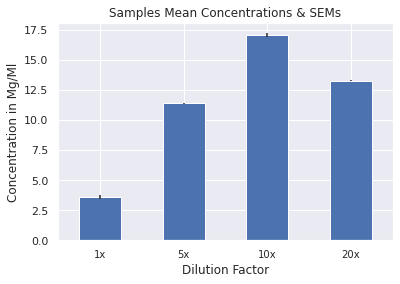

In [17]:


samples_bar_av_df = predicted_mg_per_ml[["mg/ml", "mg/ml SEM"]]
print(samples_bar_av_df)

ax4 = samples_bar_av_df.plot(kind="bar", yerr="mg/ml SEM", legend=False)
ax4.set_title("Samples Mean Concentrations & SEMs")
ax4.set_ylabel("Concentration in Mg/Ml")
ax4.set_xlabel("Dilution Factor")
plt.xticks(np.arange(samples_bar_av_df.shape[0]),acceptable_samples_list, rotation=0, fontsize="10")
plt.savefig("output/Conc_bar.png")




In [8]:
sample_data = pd.read_csv("Preconc_230308_OT2_BRADFORD_samples.csv", sep=',', header=None)
replicates = 3

sample_data = sample_data.iloc[6:,7:10]

sample_list = ["1x","5x","10x", "20x"]
replicate_list = ["Rep1", "Rep2", "Rep3"]


def process_sample_data(sample_name, sample_data_df, dilution_list, replicate_list):
    
    ## label sample df with metadata
    sample_data.columns = replicate_list
    sample_data.index = dilution_list

    
    # heatmap of absorbances
    sns.set()
    sns.heatmap(sample_data, annot=True, cmap="coolwarm")

    plt.ylabel("Dilution Factor")
    plt.title(sample_name + " : Absorbances of Diluted samples")
    plt.xlabel("Replicate #")
    plt.yticks(np.arange(sample_data.shape[0])+0.5, sample_list, rotation=0, fontsize="10")
    plt.savefig("output/"+sample_name+"_Sample_Absorbances_heat.png")

    
    # generate the means
    sample_data["Mean"] = sample_data.mean(axis=1)
    sample_data["SEM"] = sample_data.iloc[:,:3].sem(axis=1)
    samples_df_avg = sample_data[["Mean", "SEM"]]
    
    
    ax3 = samples_df_avg.plot(kind="bar", yerr="SEM", legend=False)
    ax3.set_title(sample_name + " : Mean Absorbances of Sample Dilutions")
    ax3.set_ylabel("Absorbance")
    ax3.set_xlabel("Dilution Factor")
    plt.xticks(np.arange(samples_df_avg.shape[0]),sample_list, rotation=0, fontsize="10")
    plt.savefig("output/"+sample_name+"_Sample_Absorbances_Bar.png")



    #### subset samples that don't fall in linear range
    acceptable_samples = sample_data

    #get the index again for the names
    acceptable_samples_list = acceptable_samples.index

    # convert samples
    predicted_ug_per_ml = model.predict(np.array(acceptable_samples.iloc[:,:3]).reshape(-1,1))
    predicted_ug_per_ml = np.reshape(predicted_ug_per_ml,(int(len(predicted_ug_per_ml)/replicates), replicates))
    predicted_ug_per_ml = pd.DataFrame(predicted_ug_per_ml, columns=["Rep1", "Rep2", "Rep3"], index = acceptable_samples_list)


    #account for the dilutions
    numrows = predicted_ug_per_ml.shape[0]

    for index, row in predicted_ug_per_ml.iterrows():
        # get the dilution factor from the index
        ind = str(index)
        ind = ind[:-1]
        ind = int(ind)

        predicted_ug_per_ml.loc[index, "Rep1"] = predicted_ug_per_ml.loc[index, "Rep1"]*ind
        predicted_ug_per_ml.loc[index, "Rep2"] = predicted_ug_per_ml.loc[index, "Rep2"]*ind
        predicted_ug_per_ml.loc[index, "Rep3"] = predicted_ug_per_ml.loc[index, "Rep3"]*ind


    # Use that to perform that calculations just on the right columns
    # recalculate mean and SEM

    predicted_ug_per_ml['ug/ml'] = predicted_ug_per_ml.loc[list(predicted_ug_per_ml.index),["Rep1", "Rep2","Rep3"]].mean(axis=1)
    predicted_ug_per_ml['ug/ml SEM'] = predicted_ug_per_ml.loc[list(predicted_ug_per_ml.index),["Rep1", "Rep2","Rep3"]].sem(axis=1)


    #get index to use and names
    predicted_ug_per_ml = predicted_ug_per_ml.reset_index()
    #convert all to strings
    predicted_ug_per_ml['index'] = predicted_ug_per_ml['index'].astype(str)

    ######################### convert ug/ml to mg/ml
    # grab the raw values
    predicted_mg_per_ml = predicted_ug_per_ml[['Rep1','Rep2','Rep3']]
    # convert
    predicted_mg_per_ml = predicted_mg_per_ml/1000
    # append index
    predicted_mg_per_ml['index'] = predicted_ug_per_ml['index']


    ####################### generate means and stats
    predicted_mg_per_ml['mg/ml'] = predicted_mg_per_ml.loc[list(predicted_mg_per_ml.index),["Rep1", "Rep2","Rep3"]].mean(axis=1)
    predicted_mg_per_ml['mg/ml SEM'] = predicted_mg_per_ml.loc[list(predicted_mg_per_ml.index),["Rep1", "Rep2","Rep3"]].sem(axis=1)


    samples_bar_av_df = predicted_mg_per_ml[["mg/ml", "mg/ml SEM"]]


    ax4 = samples_bar_av_df.plot(kind="bar", yerr="mg/ml SEM", legend=False)
    ax4.set_title("Samples Mean Concentrations & SEMs")
    ax4.set_ylabel("Concentration in Mg/Ml")
    ax4.set_xlabel("Dilution Factor")
    plt.xticks(np.arange(samples_bar_av_df.shape[0]),acceptable_samples_list, rotation=0, fontsize="10")
    plt.savefig("output/Conc_bar.png")

,7,8,9
6,4.543,4.060,4.506
7,3.043,3.056,3.069
8,2.453,2.469,2.508
9,1.431,1.434,1.425


In [ ]:
############### check is the SEM on the mean of means is too large.


#grab all of the replicates
checker_set_df = predicted_mg_per_ml[['Rep1', 'Rep2', 'Rep3']]

# initalise an empty series
checker_set_series = pd.Series(dtype='float64')

# go through the replicates and put them in the series
for name, values in checker_set_df.iteritems():
    checker_set_series = checker_set_series.append(values)

# reset the series
checker_set_series = checker_set_series.reset_index(drop=True)
print('')
#print('Compiled Replicates')
#print(checker_set_series)
print('')

# generate the mean and sem
checker_mean, checker_sem = (checker_set_series.mean(),checker_set_series.sem())

checker_mean_5_percent = checker_mean/20

print('Mean of means: ')
print(checker_mean)
print(' ')
print('SEM of means: ')
print(checker_sem)
print(' ')
print('Is the SEM greater than 5% of the Mean?:')
print(checker_sem > checker_mean_5_percent)

In [ ]:
############## Is the sem greater than 5% of the mean?
# If so: check for outliers.
if checker_sem > checker_mean_5_percent:
    
    ####################################################################################################################
    ####################################################################################################################
    ############### Start if Greater than BlOCK
    
    print('SEM is greater and outliers MIGHT have been identified')
    
    
    #################### box plot to identify outlier
    plt.boxplot(x=predicted_mg_per_ml['mg/ml'], vert=False)
    plt.title("Box Plot of Mean Concentrations")
    plt.xlabel("Mg/Ml")

    plt.savefig("output/Box_plot.png")
    plt.show()
    
    
    #########################################################
    #calculate interquartile range of values in the 'points' column
    q75, q25 = np.percentile(predicted_mg_per_ml['mg/ml'], [75 ,25])
    
    print(' ')
    print('q25: '+str(q25))
    print(' ')
    print('Mean: '+str(checker_mean))
    print(' ')
    print('q75: '+str(q75))
    print(' ')    
        
    ######### retain values that are within the interquartile range
    acceptable_concs = predicted_mg_per_ml.loc[(predicted_mg_per_ml["mg/ml"] >=q25) & (predicted_mg_per_ml["mg/ml"] <=q75)]

    print('The concentrations that are retained after outlier filter')
    print(' ')
    print(acceptable_concs)
    print(' ')
    

    #########################################################
    ####   plot a bar chart of the accepted concentrations
    
    barplot_df = acceptable_concs[['index','mg/ml','mg/ml SEM']]
    ax4 = barplot_df.plot(kind="bar", yerr="mg/ml SEM", legend=False)
    ax4.set_title("Samples Mean Concentrations & SEMs")
    ax4.set_ylabel("Concentration in Mg/Ml")
    ax4.set_xlabel("Dilution Factor")
    plt.xticks(np.arange(acceptable_concs.shape[0]),acceptable_concs['index'], rotation=0, fontsize="10")
    plt.savefig("output/Best_concs_bar.png")
    
    #############################################################
    ##### using the accepted concentrations to generate a consensus concentration and export it.

    subsetted = acceptable_concs[['Rep1', 'Rep2', 'Rep3']]

    compiled = pd.Series(dtype='float64')

    for name, values in subsetted.iteritems():
        compiled = compiled.append(values)

    compiled = compiled.reset_index(drop=True)
    print('')
    print('Compiled Replicates')
    print(compiled)
    print('')
    consensus_mean, consensus_sem = (compiled.mean(),compiled.sem())
    print('Generated Consensus Concentration:')
    print('consensus_mean: '+ str(consensus_mean))
    print('consensus_sem: ' + str(consensus_sem))
    consensus_num_samples = acceptable_concs.shape[0]
    print('Generated from # dilutions: ' + str(consensus_num_samples))
    
    print(' ')
    print('Saving to Consensus_concentration.csv ...')
    consensus_printout = pd.DataFrame(data = [[consensus_mean, consensus_sem, consensus_num_samples]], columns=['Consensus_Mean','Consensus_Sem','Calculated_From_#_Dilutions'])
    consensus_printout.to_csv('output/Consensus_concentration.csv')
    
    ############## END OF IF Greater than BLOCK
    ###################################################################################################################################
    ###################################################################################################################################

else:
    
    ####################################################################################################################################
    ####################################################################################################################################
    ############# Start of IF not Greater BLOCK
    
    print('SEM is not greater and no outliers have been identified')
    
    subsetted = predicted_mg_per_ml[['Rep1', 'Rep2', 'Rep3']]

    compiled = pd.Series(dtype='float64')

    for name, values in subsetted.iteritems():
        compiled = compiled.append(values)

    compiled = compiled.reset_index(drop=True)
    print('')
    print('Compiled Replicates')
    print(compiled)
    print('')
    consensus_mean, consensus_sem = (compiled.mean(),compiled.sem())
    print('Generated Consensus Concentration:')
    print('consensus_mean: '+ str(consensus_mean))
    print('consensus_sem: ' + str(consensus_sem))
    consensus_num_samples = predicted_mg_per_ml.shape[0]
    print('Generated from # dilutions: ' + str(consensus_num_samples))
    
    print(' ')
    print('Saving to Consensus_concentration.csv ...')
    consensus_printout = pd.DataFrame(data = [[consensus_mean, consensus_sem, consensus_num_samples]], columns=['Consensus_Mean','Consensus_Sem','Calculated_From_#_Dilutions'])
    consensus_printout.to_csv('Consensus_concentration.csv')


    